In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import BaggingClassifier


class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None,value=None):
        self.right = right
        self.left = left
        self.feature = feature
        self.value = value
        self.threshold = threshold

    def is_node(self):
        return self.value is not None
        

In [2]:
from collections import Counter

class DecisionTree:
    def __init__(self, max_depth = 100, min_samples_split = 2, n_features = None):
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.n_features = n_features
        self.root = None

    def fit(self, X, y): # x.shape[1] - столбцы или признаки
        self.n_features = X.shape[1] if self.n_features is None else min(X.shape[1], self.n_features)
        self.root = self._grow_tree(X, y)

    def _grow_tree(self, X, y, depth = 0):
        n_samples, n_feat = X.shape
        # посчитаем сколько уникальных классов - понадобится для разбиения
        n_labels = len(np.unique(y))
        # критери остановы
        if depth >= self.max_depth or n_labels == 1 or n_samples < self.min_samples_split:
            leaf_value = self._most_common_label(y)
            return Node(value=leaf_value)
        feat_idxs = np.random.choice(n_feat, self.n_features, replace = False) # случайно берем признак
        # ищем лучшее разбиение
        best_feature, best_thresh = self._best_split(X, y, feat_idxs)
        # строим левое и правое поддерево
        left_idxs, right_idxs = self._split(X[:, best_feature], best_thresh)
        left = self._grow_tree(X[left_idxs, :], y[left_idxs], depth + 1)
        right = self._grow_tree(X[right_idxs, :], y[right_idxs], depth + 1)
        return Node(best_feature, best_thresh, left, right)


    def _best_split(self, X, y, feat_idxs):
        best_gain = -1
        split_idxs, split_threshold = None, None

        for feat_idx in feat_idxs:
            X_column = X[:, feat_idx]
            thresholds = np.unique(X_column) # берем все уникальные знач признака
            for thr in thresholds:
                # Для каждого порога thr считаем gain info
                gain = self._information_gain(y, X_column, thr)
                if gain > best_gain:
                    best_gain = gain
                    split_idxs = feat_idx
                    split_threshold = thr
                    
        return split_idxs, split_threshold

    def _information_gain(self, y, X_column, threshold):
        parent_entropy = self._entropy(y)
        left_idxs, right_idxs = self._split(X_column, threshold)
        if len(left_idxs) == 0 or len(right_idxs) == 0:
            return 0

        n = len(y)
        n_l, n_r = len(left_idxs), len(right_idxs)
        e_l = self._entropy(y[left_idxs])
        e_r = self._entropy(y[right_idxs])
        child_entropy = (n_l / n) * e_l + (n_r / n) * e_r
        information_gain = parent_entropy - child_entropy
        return information_gain



    def _split(self, X_column, threshold):
        left_idxs = np.argwhere(X_column <= threshold).flatten()
        right_idxs = np.argwhere(X_column > threshold).flatten()
        return left_idxs, right_idxs


    def _entropy(self, y):
        #Энтропия — это мера неопределённости / "хаоса" в выборке.
        #Чем больше разные классы перемешаны, тем выше энтропия.
        hist = np.bincount(y)
        ps = hist / len(y)
        return -np.sum([p * np.log(p) for p in ps if p>0])
        
    def _most_common_label(self, y):
        counter = Counter(y)
        value = counter.most_common(1)[0][0]
        return value
    
    def predict(self, X):
        return np.array([self._traverse_tree(x, self.root) for x in X])

    def _traverse_tree(self, x, node):
        if node.is_node():
            return node.value

        if x[node.feature] <= node.threshold:
            return self._traverse_tree(x, node.left)
        return self._traverse_tree(x, node.right)
        

Протестируем на данных

In [3]:
!wget -O "train.csv" -q "https://www.dropbox.com/s/q8i2v0slgznh7ti/bill_authentication.csv?dl=0"


In [4]:
train = pd.read_csv('train.csv')
train.sample(3)

,Variance,Skewness,Curtosis,Entropy,Class
421,-1.14970,1.2954,7.7010,0.62627,0
648,0.77765,5.9781,1.1941,-0.35260,0
1184,-0.73510,1.7361,-1.4938,-1.15820,1


In [5]:
y = train['Class']
X = train.drop(columns='Class')

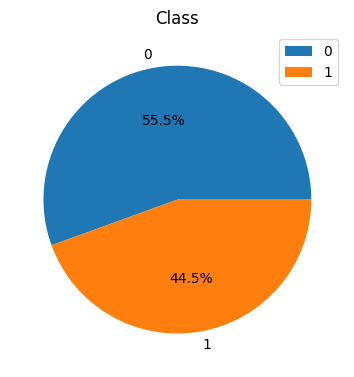

In [6]:
plt.figure(figsize =(20, 20))
data_i=y.value_counts()
plt.subplot(4,4,1)
plt.pie(data_i, labels = data_i.index, autopct='%1.1f%%')
plt.title('Class')
plt.legend()
None

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Sklearn Decision Tree

In [8]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train, y_train)


DecisionTreeClassifier(max_depth=5)

In [9]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

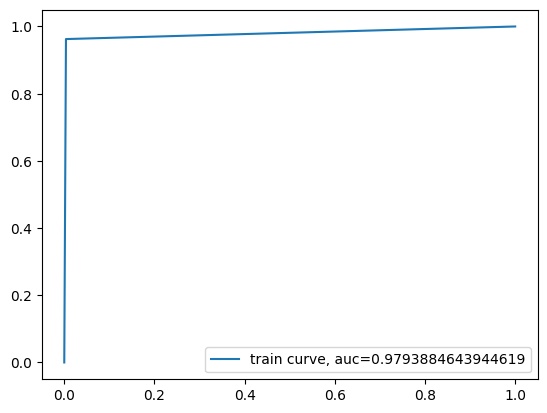

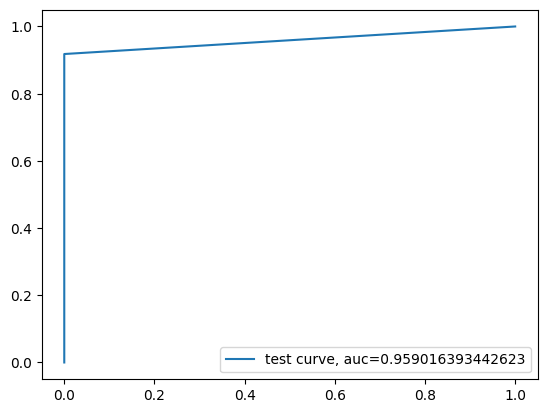

In [10]:
fpr, tpr, _ = metrics.roc_curve(y_train,  train_pred)
auc = metrics.roc_auc_score(y_train,  train_pred)
plt.plot(fpr,tpr,label="train curve, auc="+str(auc))
plt.legend(loc=4)
plt.show()

fpr, tpr, _ = metrics.roc_curve(y_test,  test_pred)
auc = metrics.roc_auc_score(y_test, test_pred)
plt.plot(fpr,tpr,label="test curve, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [11]:
print('f1_train = ', metrics.f1_score(y_train, train_pred))
print('f1_test = ', metrics.f1_score(y_test, test_pred))

print('recall_train = ', metrics.recall_score(y_train, train_pred))
print('recall_test = ', metrics.recall_score(y_test, test_pred))

print('precision_train = ', metrics.precision_score(y_train, train_pred))
print('precision_test = ', metrics.precision_score(y_test, test_pred))

print('accuracy_train = ', metrics.accuracy_score(y_train, train_pred))
print('accuracy_test = ', metrics.accuracy_score(y_test, test_pred))

f1_train =  0.9785714285714285
f1_test =  0.9572649572649572
recall_train =  0.9625292740046838
recall_test =  0.9180327868852459
precision_train =  0.9951573849878934
precision_test =  1.0
accuracy_train =  0.98125
accuracy_test =  0.9635922330097088


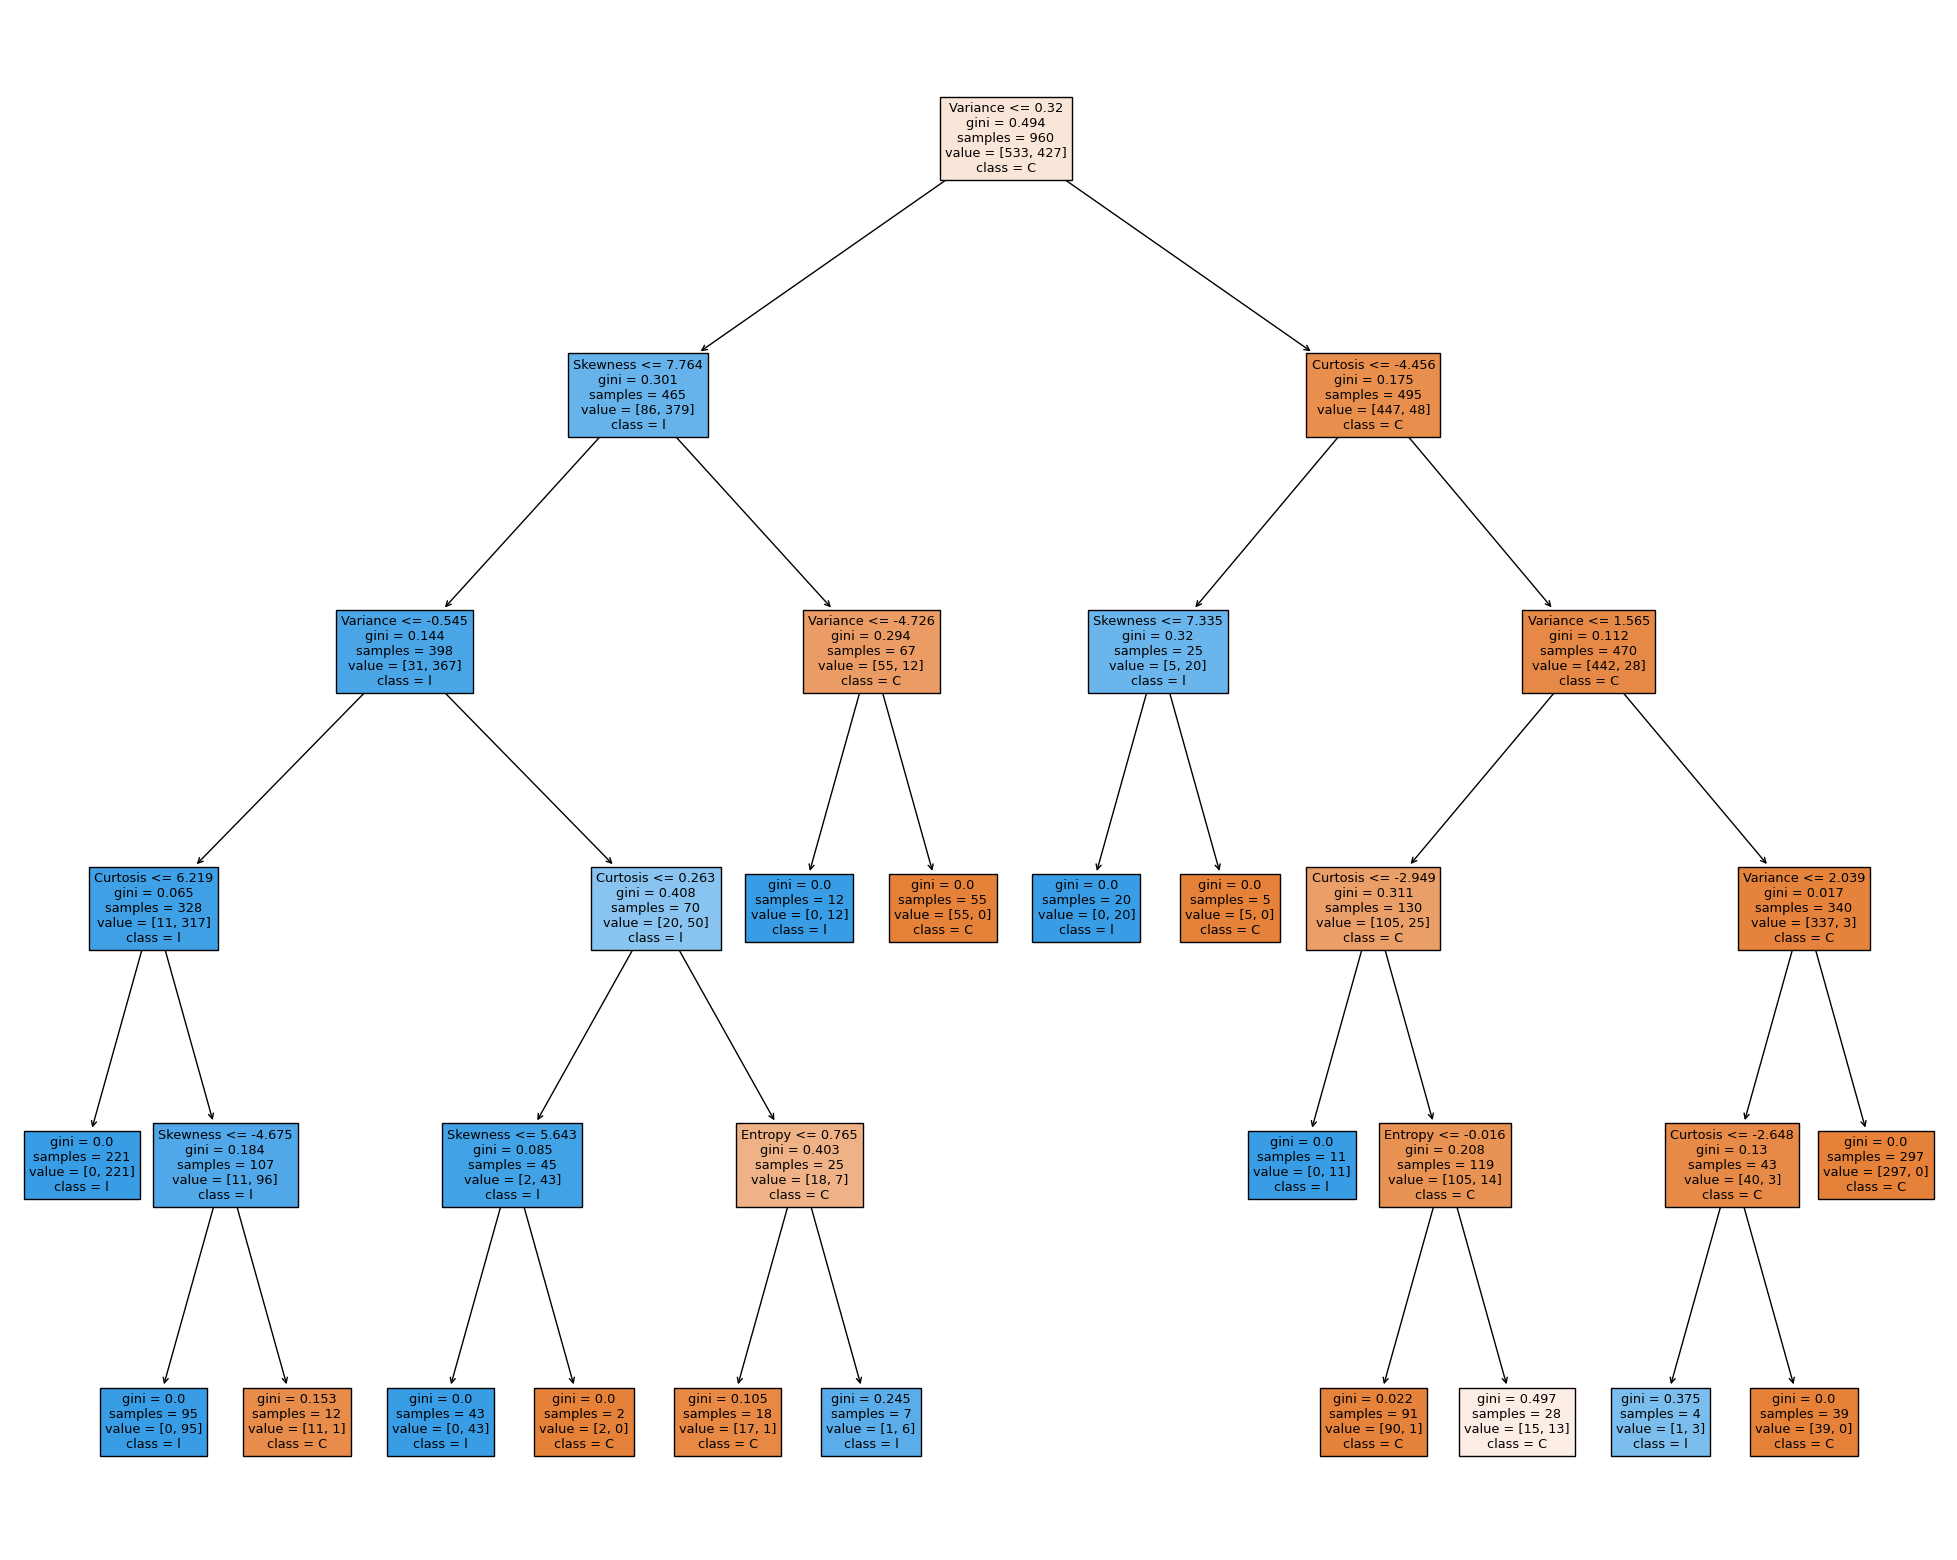

In [12]:
from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(clf, 
                   feature_names=X.columns,  
                   class_names='Class',
                   filled=True)

My Decision Tree


In [13]:
clf = DecisionTree(max_depth = 5)


In [14]:
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [15]:
clf.fit(X_train, y_train)

In [16]:
train_pred = clf.predict(X_train)
test_pred = clf.predict(X_test)

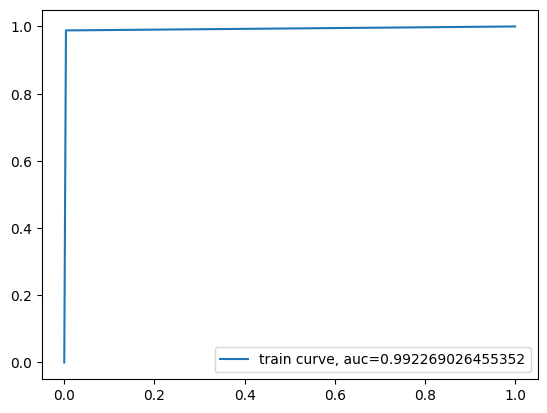

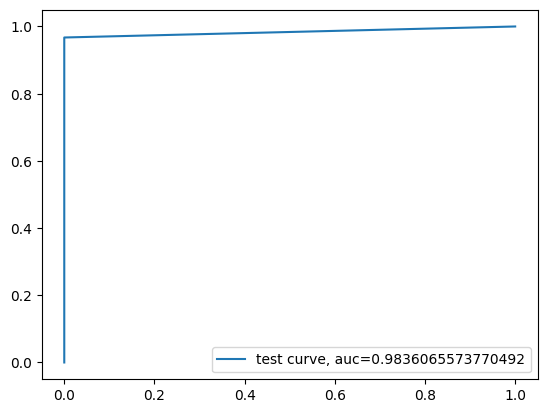

In [17]:
fpr, tpr, _ = metrics.roc_curve(y_train,  train_pred)
auc = metrics.roc_auc_score(y_train,  train_pred)
plt.plot(fpr,tpr,label="train curve, auc="+str(auc))
plt.legend(loc=4)
plt.show()

fpr, tpr, _ = metrics.roc_curve(y_test,  test_pred)
auc = metrics.roc_auc_score(y_test, test_pred)
plt.plot(fpr,tpr,label="test curve, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [18]:
print('f1_train = ', metrics.f1_score(y_train, train_pred))
print('f1_test = ', metrics.f1_score(y_test, test_pred))

print('recall_train = ', metrics.recall_score(y_train, train_pred))
print('recall_test = ', metrics.recall_score(y_test, test_pred))

print('precision_train = ', metrics.precision_score(y_train, train_pred))
print('precision_test = ', metrics.precision_score(y_test, test_pred))

print('accuracy_train = ', metrics.accuracy_score(y_train, train_pred))
print('accuracy_test = ', metrics.accuracy_score(y_test, test_pred))

f1_train =  0.9917743830787309
f1_test =  0.9833333333333333
recall_train =  0.9882903981264637
recall_test =  0.9672131147540983
precision_train =  0.9952830188679245
precision_test =  1.0
accuracy_train =  0.9927083333333333
accuracy_test =  0.9854368932038835


Метрики очень похожи